# Problem sheet 2 - Q4: Naive Bayes and SVM

1. [Preprocessing](#1)
2. [MLEs for Multinomial NB](#2)
3. [Posterior probabilities](#3)
4. [Scoring functions](#4)
5. [Computing NB distributions and prediction](#5)
6. [SVM with Simple SMO](#6)
7. [Train and predict with SVM](#7)
8. [Comparison with sklearn](#8)
9. [Next steps](#9)

The objective of the question is to investigate the relative performance of Naive Bayes and SVM classifiers with respect to the size of the training set. We do this with the classic task of spam classification, where NB is generally expected to perform very well. In this notebook we will implement both of these algorithms from scratch, train them on the [SMS spam classification dataset](http://archive.ics.uci.edu/ml/datasets/SMS+Spam+Collection) (which we will have to preprocess) from the UCI Machine Learning Repository and plot the accuracy of these algorithms as a function of the size of the training set. We will also compare the results of our algorithms to the corresponding ones from `sklearn`. Note also that we decided to implement the multinomial variant of Naive Bayes. This means we also track the frequencies of words rather than just their presence. It is perhaps not so useful for short messages like SMS, but if we apply the same model to longer texts, such as emails, it is plausible that the multinomial model could perform better than the standard Bernoulli one.

## 1. Preprocessing <a id="1"></a>

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.sparse import load_npz
from skmultilearn.dataset import load_from_arff

# you have to provide the dataset from the above url yourself:
data = pd.read_csv('smsspamcollection/SMSSpamCollection', sep='\t', names=['spam_class', 'spam_text'])
data.head()

,spam_class,spam_text
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [2]:
data.spam_class.value_counts()

ham     4825
spam     747
Name: spam_class, dtype: int64

We notice that the classes are very unbalanced so we make sure to split the training and validation data in a stratified manner. This is far from perfect though and in reality we could try to assign class weights or, better yet, use a test set with balanced classes to accurately measure our performance. However, we leave this for future work.

The raw data seen above has to be processed into a format suitable for text classification. Below we first map the target to 1 for spam messages and -1 for non-spam and then remove all unnecessary punctuation and (a limited) amount of stop words. Finally we use the native python ``Counter`` class to keep track of the frequencies of words in each message in order to construct our feature vectors.

In [3]:
from collections import Counter

df = data.copy()
df['spam_class'] = df['spam_class'].map({'ham': -1, 'spam': 1})
df['spam_text'] = df['spam_text'].apply(lambda s: "".join([c for c in s if c not in ",.;:?!*()[]{}\'\"&_<>/\\"]).lower())
stop_words = ['a', 'an', 'the', 'is', 'it', 'he', 'she', 'us', 'we', 'you', 'your', 'me', 'i', 'him', 'her']
df['spam_text'] = df['spam_text'].apply(lambda s: " ".join([w for w in s.split() if w not in stop_words]))

counts = pd.DataFrame([Counter(s.split()) for s in df['spam_text']]).fillna(0).astype('int')
df = df.join(counts)

We use a random sample of 20% of our data as the cross-validation set. From the remaining 80% we create train sets of various sizes by independent sampling.

In [4]:
from sklearn.model_selection import train_test_split

# seed for all of our random number generators
rng_seed = 1

X = df.drop(columns=['spam_text', 'spam_class'])
y = df.spam_class

X_train, X_val, y_train, y_val = train_test_split(X,
                                                  y,
                                                  train_size=.8,
                                                  stratify=y,
                                                  random_state=rng_seed)

X_train = np.array(X_train)
y_train = np.array(y_train)
X_val = np.array(X_val)
y_val = np.array(y_val)

In [5]:
np.sum(y_val == 1) / np.sum(y == 1)

0.1994645247657296

We see that the stratified split dedicated about 20% of the rare events (spam) into our validation set, as expected. For the actual training sets we do not do any conditioning on the presence of particular labels in y. This is because even with very unbalanced and small datasets we would expect NB to do very well because of the strong priors and we want to compare this performance to SVM.

In [6]:
# now create train sets of different sizes:

train_size = [25, 50, 100, 200, 300, 400, 500, 750, 1000, 1250, 1500, 1750, 2000, 2250, 2500]

X_trains = {}
y_trains = {}

i = 0

for size in train_size:
    gen = np.random.default_rng(rng_seed + i)
    rows = gen.choice(len(X_train), size=size)
    X_trains[size] = X_train[rows]
    y_trains[size] = y_train[rows]
    i += 1

results = pd.DataFrame(data=None, index=train_size)
models = ['NB', 'SVM']
scores = pd.DataFrame(data=None, index=pd.MultiIndex.from_product([models, train_size],
                                                                  names=['model', 'train_size']),
                     columns=['TP', 'FP', 'FN', 'TN', 'accuracy', 'precision', 'recall', 'specificity', 'F1'], dtype='float')

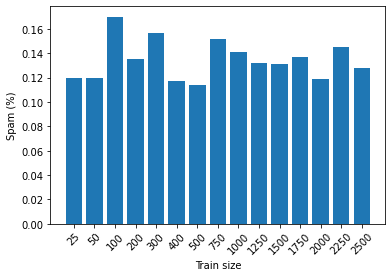

In [7]:
spam_frac = [np.sum(y_trains[size]==1) / size for size in train_size]
plt.bar(np.arange(len(train_size)), spam_frac, tick_label=train_size)
plt.xticks(rotation=45)
plt.xlabel('Train size')
plt.ylabel('Spam (%)')
plt.show()

It seems the proportion of spam in most training sets is about uniform.

## 2. MLEs for Multinomial NB <a id="2"></a>

First we compute the maximum likelihood estimates for multinomial Naive Bayes. Recall that our goal is to estimate
$p(y|x)$, where $x=(x_{1},\ldots,x_{n})^{T}$ is a feature vector of size equal to the number of words in our dictionary and $\sum x_{i}=\text{length of message}$. We make two (strong) assumptions:
1. *Conditional independence*: the random variables $x_{i}|y$ are mutually independent for all $i$.
2. *Prior probabilities*: $x|y=j\sim\mathrm{Multinomial}(n, \mathbf{p}_{j})$, where the vector $\mathbf{p}_{j}$ consists of probabilities that each word occurs in spam ($y=1)$ or non-spam ($y=-1$).

Finally, we also assume that $y\sim\mathrm{Bernoulli}(p_{y})$. Below we define a function that computes the maximum likelihood estimates of these parameters with an additional smoothing parameter (to prevent zero probabilities).

In [8]:
def compute_MLEs(X, y):
    # with Laplace smoothing
    smoothing = 1.0
    # m = number of training examples
    # n = number of features
    m, n = X.shape
    spam_count = np.sum(y[np.where(y == 1)])
    nonspam_count = m - spam_count
    
    p_y = spam_count / m
    
    p_j0 = (np.sum(X[np.nonzero(y.ravel() == -1)[0], :], axis=0) + smoothing) / (np.sum(X) + smoothing * n)
    p_j1 = (np.sum(X[np.nonzero(y.ravel() == 1)[0], :], axis=0) + smoothing) / (np.sum(X) + smoothing * n)
    
    return p_j1, p_j0, p_y

## 3. Posterior probabilities <a id="3"></a>

Once we have the parameters, we can compute the posterior probability $p(y=j|x)$ through Bayes' theorem. There are a few simplifications we make in order to increase the efficiency of the algorithm. First, in the pdf of $x|y=j$ (which is $(\sum x_{i})! / (\prod x_{i}! \prod p_{j, i}^{x_{i}})$) we can ignore the factorials since in terms of our optimisation problem they are constants. In the same way, we can also ignore the denominator of the posterior probability (i.e. $p(x)$) after applying Bayes' theorem. Further, we also choose to work with $\log$-probabilities, because a) it makes the computations inside our classifier linear, b) it decreases the numerical precision that we have to use for the same level of accuracy. For the sake of comparison we have also included the code for the standard hypothesis function (with actual probabilities) inside the comment below.

In [9]:
#def predict(X, p_j1, p_j0, p_y):
#    p_x_given_y1 = np.prod(np.power(p_j1, X, dtype='float128'),axis=1) * p_y
#    p_x_given_y0 = np.prod(np.power(p_j0, X, dtype='float128'),axis=1) * (1 - p_y)
#    spam_prop = np.divide(p_x_given_y1, p_x_given_y1 + p_x_given_y0)
#    pred = np.ones(spam_prop.shape)
#    pred[np.where(spam_prop <= 0.5)] = -1
#    return pred

def predict_logs(X, p_j1, p_j0, p_y):
    p_x_given_y1 = np.sum(np.multiply(np.log(p_j1), X, dtype='float64'), axis=1) + np.log(p_y)
    p_x_given_y0 = np.sum(np.multiply(np.log(p_j0), X, dtype='float64'), axis=1) + np.log(1 - p_y)
    
    pred = np.ones(X.shape[0])
    pred[np.nonzero(p_x_given_y0 > p_x_given_y1)] = -1
    return pred

## 4. Scoring functions <a id="4"></a>

The evaluation metric we choose to use is just the proportion of misclassifications (i.e. $1-\text{accuracy}$). We will also keep track of all the standard quantities for evaluating a classifier performance (precision, recall, $F1$-score etc.).

In [10]:
def getScore(preds, y):
    # returns error rate (%)
    return 100 * np.sum(preds.ravel() != y.ravel()) / len(preds)


def confusionMatrix(pred, y):   
    m = len(y)
    
    pos_idx = np.nonzero(y == 1)
    neg_idx = np.nonzero(y == -1)
    
    TP = np.sum(pred[pos_idx] == 1)
    TN = np.sum(pred[neg_idx] == -1)
    # Type 1 error
    FP = np.sum(pred == 1) - TP
    # Type 2 error
    FN = np.sum(pred == -1) - TN
    
    accuracy = (TP + TN) / m
    precision = TP / (TP + FP)
    recall = TP / (TP + FN)
    specificity = TN / (TN + FP)
    F1 = 2 * precision * recall / (precision + recall)
    
    return {'TP': TP, 'FP': FP, 'FN': FN, 'TN': TN, 'accuracy': accuracy, 'precision': precision, 'recall': recall, 'specificity': specificity, 'F1': F1}

## 5. Computing NB distributions and prediction <a id="5"></a>

In [11]:
for size in train_size:
    p_j1, p_j0, p_y = compute_MLEs(X_trains[size], y_trains[size])
    pred = predict_logs(X_val, p_j1, p_j0, p_y)
    results.loc[size, 'scores_NB_val'] = getScore(pred, y_val)
    scores.loc[('NB', size)] = confusionMatrix(pred, y_val)
    # let's also get the train errors
    pred = predict_logs(X_trains[size], p_j1, p_j0, p_y)
    results.loc[size, 'scores_NB_train'] = getScore(pred, y_trains[size])

<ipython-input-10-f9a662f0f778>:23: RuntimeWarning: invalid value encountered in double_scalars
  F1 = 2 * precision * recall / (precision + recall)


In [12]:
scores.loc['NB']

,TP,FP,FN,TN,accuracy,precision,recall,specificity,F1
train_size,,,,,,,,,
25,0.0,1.0,149.0,965.0,0.865471,0.0,0.000000,0.998965,NaN
50,4.0,0.0,145.0,966.0,0.869955,1.0,0.026846,1.000000,0.052288
100,55.0,0.0,94.0,966.0,0.915695,1.0,0.369128,1.000000,0.539216
200,25.0,0.0,124.0,966.0,0.888789,1.0,0.167785,1.000000,0.287356
300,56.0,0.0,93.0,966.0,0.916592,1.0,0.375839,1.000000,0.546341
400,26.0,0.0,123.0,966.0,0.889686,1.0,0.174497,1.000000,0.297143
500,32.0,0.0,117.0,966.0,0.895067,1.0,0.214765,1.000000,0.353591
750,71.0,0.0,78.0,966.0,0.930045,1.0,0.476510,1.000000,0.645455
1000,80.0,0.0,69.0,966.0,0.938117,1.0,0.536913,1.000000,0.698690


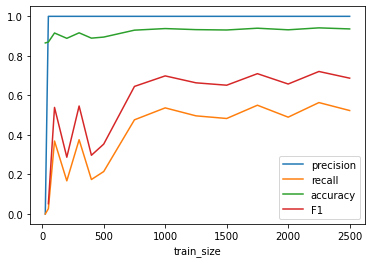

In [13]:
scores.loc['NB'].plot(use_index=True, y=['precision', 'recall', 'accuracy', 'F1']);

Notice that precision (the amount of true positives out of all positives) is extremely high for all training sets, whereas recall barely reaches over 50% for just a few of the training sets. In other words, we make a lot of Type II errors, but hardly any (or none) Type I errors. This is a desirable property for a spam filter, because we would rather the user sees some spam, but doesn't miss any important messages rather than losing authentic texts to the spam filter. It would be worth experiment how precision and recall are affected if we use more balanced data.

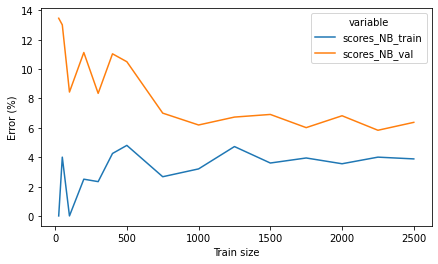

In [14]:
# plot the learning curve

fig, ax = plt.subplots(figsize=(7,4))
ax.set(xlabel='Train size', ylabel='Error (%)')
sns.lineplot(data=pd.melt(results.reset_index(), id_vars='index', value_vars=['scores_NB_train', 'scores_NB_val']),
             x='index', y='value', hue='variable', ax=ax)
plt.show()

From the learning curve we notice that the errors stabilise fairly quickly (as we would expect for such a low variance model), but exhibits high bias as is expected from NB. On the other hand it is not clear whether the validation error could still be improved by increasing the size of the training set.

## 6. SVM with simple SMO<a id="6"></a>
Next we'll implement an SVM algorithm (with linear kernel) by using a simplified version (as given in the lecture notes) of the [Sequential Minimal Optimisation](https://www.microsoft.com/en-us/research/wp-content/uploads/2016/02/tr-98-14.pdf) algorithm by J. Platt (1998). Recall that in SVM the objective is to solve the optimisation problem
$$\mathrm{argmin}_{w, b}\tfrac{1}{2}\lVert w\rVert^{2}+C\sum_{j=1}^{m}\xi_{j},$$
subject to
$$y^{(i)}(w^{T}x^{(i)}+b)\geq 1-\xi_{i},$$
$$\xi_{i}\geq 0,$$
for all $i$. Here the $\xi_{i}$'s control how much leeway we allow for the training examples to cross the functional margin of our classifier. To use SMO we consider the dual form of the problem:
$$\mathrm{argmax}_{\alpha} \sum_{i}\alpha_{i} - \tfrac{1}{2}\sum_{i,j} y^{(i)}y^{(j)}\alpha_{i}\alpha_{j} K(x^{(i)}, x^{(j)})$$
subject to
$$0\leq \alpha_{i}\leq C,$$
$$\sum_{i}\alpha_{i}y^{(i)}=0,$$
for all $i$. Here $K$ is the kernel function, but for simplicity we just use $K(a, b)= \langle a, b\rangle$ with the standard inner product on $\mathbb{R}^{m}$. The final model can then be expressed in terms of the $\alpha$ and $b$ parameters as
$$h(x) = \sum_{i}\alpha_{i}y^{(i)}K(x^{(i)}, x) + b.$$

The crux of the SMO algorithm is to optimise only two of the parameters, say, $\alpha_{i}$ and $\alpha_{j}$ at a time while keeping everything else fixed. In our implementation the main simplification versus the full algorithm is that we select the pair of parameters we want to minimise more or less at random (as opposed to a more sophisticated heuristic). This makes our code simpler at the expense of negatively affecting the convergence properties of the algorithm. The model takes 3 hyperparameters:
- $C$ is the weight of the regularisation term in the cost function,
- `max_passes` is the maximum number of times we iterate over the parameters without any of them changing (by more than $10^{-5}$),
- `tol` controls the tolerance to which we want the KKT (Karush-Kuhn-Tucker) conditions to be satisfied before we terminate the algorithm. A typical default value is $10^{-3}$.

In [15]:
# This helper function picks the correct lower (L) and upper (H) bounds for the alpha's in order to ensure
# that they fall within the box given by the KKT conditions
def pick_LH(i, j, y, alpha, C):   
    if y[i] != y[j]:
        L = max(0, alpha[j] - alpha[i])
        H = min(C, C + alpha[j] - alpha[i])
    else:
        L = max(0, alpha[i] + alpha[j] - C)
        H = min(C, alpha[i] + alpha[j])

    return L, H
    

# We speed up the computation of the hypothesis function for vectors from our training set
# since we have already computed the inner products
def h_from_idx(j: int, inner_prods, y, alpha, b):  
    return np.dot(np.multiply(alpha, y), inner_prods[:, j]) + b

    
def Simple_SMO(X, y, C, max_passes=5, tol = 0.001, K=lambda s: s):    
    y = np.array(y).ravel()
    m = X.shape[0]
    
    alpha = np.zeros((m))
    b = 0
    passes = 0
    
    inner_prods = K(X @ X.T)
    
    while passes < max_passes:
        changed_alphas = 0
        
        for i in range(m):
            alpha_i = alpha[i]
            E_i = h_from_idx(i, inner_prods, y, alpha, b) - y[i]
            
            if ((y[i] * E_i < -tol) and (alpha_i < C) or
                (y[i] * E_i > tol) and (alpha_i > 0)):
                
                rng = np.random.default_rng()
                j = int(rng.choice(np.delete(alpha, i), 1).item())
                alpha_j = alpha[j]
                               
                E_j = h_from_idx(j, inner_prods, y, alpha, b) - y[j]
                
                L, H = pick_LH(i, j, y, alpha, C)
                
                if L == H:
                    continue
                
                eta = 2 * inner_prods[i, j] - inner_prods[i, i] - inner_prods[j, j]
                
                if eta >= 0:
                    continue
                
                # we need to retain old alpha_j and alpha_i
                alpha_j_cand = alpha_j - y[j] * (E_i - E_j) / eta
                alpha_j_cand = min(max(alpha_j_cand, L), H)
        
                if abs(alpha_j_cand - alpha_j) < 10e-5:
                    continue
                
                alpha_i_cand = alpha_i + y[i] * y[j] * (alpha_j - alpha_j_cand)
                
                b_1 = (b - E_i - y[i] * (alpha_i_cand - alpha_i) * inner_prods[i, i]
                       - y[j] * (alpha_j_cand - alpha_j) * inner_prods[i, j])
                b_2 = (b - E_j - y[i] * (alpha_i_cand - alpha_i) * inner_prods[i, j]
                       - y[j] * (alpha_j_cand - alpha_j) * inner_prods[j, j])
        
                # now we can update alpha_i, j
                alpha_i, alpha_j = alpha_i_cand, alpha_j_cand
                alpha[i], alpha[j] = alpha_i, alpha_j
                
                changed_alphas += 1
                
                # if both alpha_i,j are < C then b_1 = b_2
                if alpha_i > 0 and alpha_i < C:
                    b = b_1
                elif alpha_j > 0 and alpha_j < C:
                    b = b_2
                else:
                    b = (b_1 + b_2) / 2
                    
        if changed_alphas == 0:
            passes += 1
        else:
            passes = 0
        
    return alpha, b


def SVM(X, y, C, max_passes=5, tol=0.001):  
    alpha, b = Simple_SMO(X, y, C, max_passes, tol)
    # we need to reconstruct the w vector from the alpha parameters given by the dual optimisation problem
    w = np.sum(np.multiply(X, np.multiply(alpha, y).reshape(-1,1)), axis = 0).T

    return w, b


def predict_SVM(X, w, b):
    # the separating hyperplane is X @ w + b = 0
    return np.where((X @ w + b) > 0, 1, -1)

## 7. Train and predict with SVM<a id="7"></a>

Notice that sometimes when computing one of the metrics, we might end up dividing by zero (e.g. if everything is classified as negative for a small sample). We'll just ignore this and treat the value as NaN.

In [16]:
for size in train_size:
    w, b = SVM(X_trains[size], y_trains[size], 1, max_passes=5)
    
    pred = predict_SVM(X_val, w, b)
    results.loc[size, 'scores_SVM_val'] = getScore(pred, y_val)
    scores.loc[('SVM', size)] = confusionMatrix(pred, y_val)
    # and compute the train errors
    pred = predict_SVM(X_trains[size], w, b)
    results.loc[size, 'scores_SVM_train'] = getScore(pred, y_trains[size])

<ipython-input-10-f9a662f0f778>:20: RuntimeWarning: invalid value encountered in long_scalars
  precision = TP / (TP + FP)


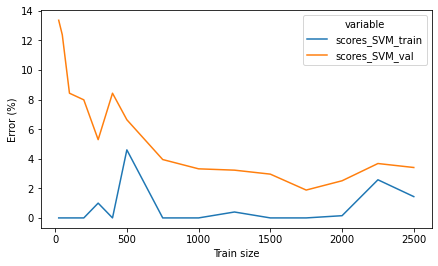

In [17]:
fig, ax = plt.subplots(figsize=(7,4))
ax.set(xlabel='Train size', ylabel='Error (%)')
sns.lineplot(data=pd.melt(results.reset_index(), id_vars='index', value_vars=['scores_SVM_train', 'scores_SVM_val']),
             x='index', y='value', hue='variable', ax=ax)
plt.show()

It seems our model has fairly low bias with a little bit of variance, but based on the learning curves we would expect the model to converge to an almost optimal solution given more training data. We expect the irreducible error to be extremely small, because it's generally easy for humans to tell spam apart from authentic messages.

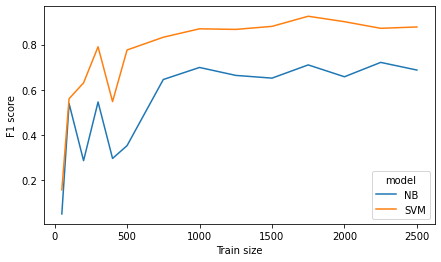

In [18]:
#scores.reset_index('model')
fig, ax = plt.subplots(figsize=(7,4))
ax.set(xlabel='Train size', ylabel='F1 score')
sns.lineplot(data=scores.reset_index(), x='train_size', y='F1', hue='model')
plt.show()

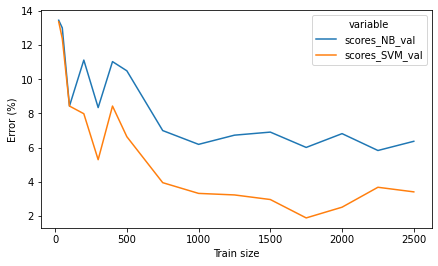

In [19]:
fig, ax = plt.subplots(figsize=(7,4))
ax.set(xlabel='Train size', ylabel='Error (%)')
sns.lineplot(data=pd.melt(results.reset_index(), id_vars='index', value_vars=['scores_NB_val', 'scores_SVM_val']),
             x='index', y='value', hue='variable', ax=ax)
plt.show()

We see that SVM does outperform NB as expected, although something unexpected happens around train size 2000. It could be interesting to investigate this further (e.g. what kind of messages get suddenly misclassified at such a higher rate). Moreover, we notice that even for small training set sizes our SVM algorithm performs very well. Typically we expect NB to beat SVM for very small samples since with NB there is no training involved and it makes much stronger assumptions (by fixing prior distributions).

## 8. Comparison with sklearn<a id="8"></a>

We again compare our models with the ones from `sklearn`. Keep in mind that `sklearn.svm.SVC` implements the full SMO algorithm.

In [20]:
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB

for size in train_size:
    model = MultinomialNB()
    model.fit(X_trains[size], y_trains[size].ravel())
    preds = model.predict(X_val)
    results.loc[size, 'scores_NB_sklearn_val'] = getScore(preds, y_val)

    model = SVC(kernel='linear', random_state=0)
    model.fit(X_trains[size], y_trains[size].ravel())
    preds = model.predict(X_val)
    results.loc[size, 'scores_SVM_sklearn_val'] = getScore(preds, y_val)

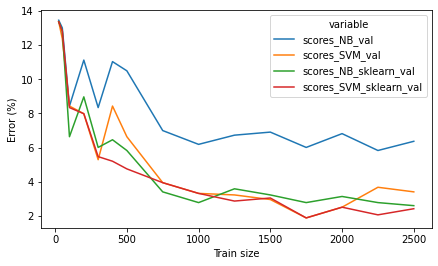

In [21]:
fig, ax = plt.subplots(figsize=(7,4))
ax.set(xlabel='Train size', ylabel='Error (%)')
sns.lineplot(data=pd.melt(results.reset_index(), id_vars='index',
                          value_vars=['scores_NB_val', 'scores_SVM_val', 'scores_NB_sklearn_val', 'scores_SVM_sklearn_val']),
             x='index', y='value', hue='variable', ax=ax)
plt.show()

Unsurprisingly, the more complicated models perform extremely well for such a simple task given enough data. What _is_ surprising though is that sklearn's NB algorithm performs comparatively to (or even beats) all other models. This could be for two main reason: first, the problem is fairly simple and the prior distribution is accurate so NB is able to capture the features of the data fully and the stronger generalisation power of SVM's is not needed (nor useful); second, we haven't done any hyperparameter tuning and it's possible that we could further increase the performance of the SVM models and beat NB.

## 9. Next steps<a id="9"></a>

Here are some ideas for future work:

- Implement alternative kernels. This is not too difficult, but we would need to change the logic a bit since the kernel matrix is needed at inference time.
- Investigate sklearn's implementation of multinomial NB and try to understand why it does so much better than our version. 